<a href="https://www.kaggle.com/parthplc/facebook-hateful-meme-dataset">Data source</a>

In [1]:
import pandas as pd 
import numpy as np 
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from IPython.display import display
from sklearn.metrics import classification_report,roc_auc_score
from utils import Preprocess
import cv2 
import joblib
plt.style.use('seaborn')

d:\6thSem\NLP\Final\env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
TRAIN_PATH = 'train.jsonl'
TEST_PROPORTION = 0.1 
MAPPING = {
    0:'Normal',
    1:'Hateful',
}
BLUR_SIZE = (40,40)

In [3]:
train = pd.read_json(TRAIN_PATH,lines=True)

In [4]:
train.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [5]:
train = train[['text','label']]

In [6]:
train['label'].value_counts()

0    5450
1    3050
Name: label, dtype: int64

In [7]:
train['label'] = train['label'].map(MAPPING)

In [8]:
train['label'].value_counts()

Normal     5450
Hateful    3050
Name: label, dtype: int64

In [9]:
normal_df = train[train['label'] == 'Normal']
hateful_df = train[train['label'] == 'Hateful']

In [10]:
normal_sample = normal_df.sample(hateful_df.shape[0])

In [11]:
assert normal_sample.shape == hateful_df.shape

In [12]:
data = pd.concat([hateful_df, normal_sample], axis=0)
data = data.sample(frac=1)
data.reset_index(drop=True, inplace=True)

In [13]:
data.head()

,text,label
0,goes on tinder instead of match.com,Normal
1,if this is what they call pride.. then i don't...,Hateful
2,when you have to stand very still bc there's a...,Normal
3,this one time at camp we got so baked,Normal
4,when a girl says she is lesbian so you become ...,Hateful


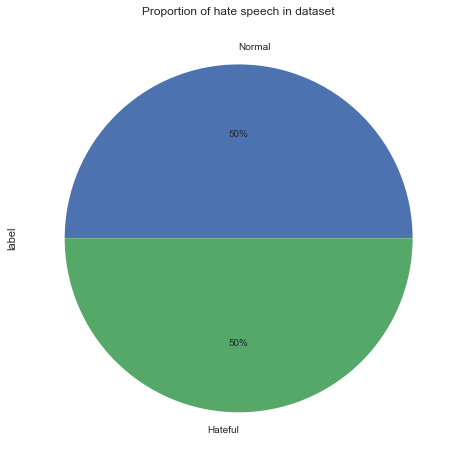

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
data['label'].value_counts().plot(kind='pie', autopct='%1.0f%%', ax=ax,title='Proportion of hate speech in dataset')
plt.show()

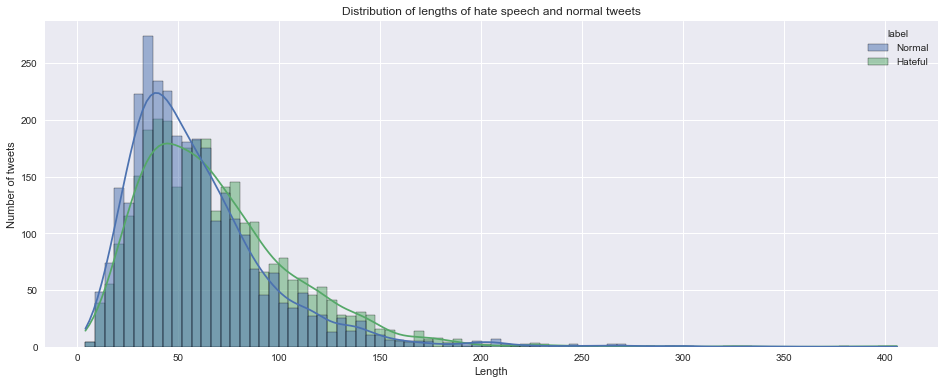

In [15]:
length = data['text'].apply(len)
fig, ax = plt.subplots(figsize=(16,6))
sns.histplot(x=length, hue=data['label'], kde=True, ax=ax)
ax.set_title('Distribution of lengths of hate speech and normal tweets')
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Length')
plt.show()

In [16]:
data['length'] = length
display(data.groupby(by='label')['length'].describe().transpose())

label,Hateful,Normal
count,3050.000000,3050.000000
mean,68.483607,59.550492
std,39.450920,36.007355
min,4.000000,4.000000
25%,40.000000,35.000000
50%,61.000000,51.000000
75%,88.000000,74.000000
max,406.000000,334.000000


In [17]:
normal = data[data['label'] == 'Normal']
offensive = data[data['label'] == 'Hateful']

In [18]:
normal_corpus = ' '.join([row['text'] for _, row in normal.iterrows()])
offensive_corpus = ' '.join([row['text'] for _, row in offensive.iterrows()])

In [19]:
hate_cloud = WordCloud().generate(offensive_corpus)
normal_cloud = WordCloud().generate(normal_corpus)

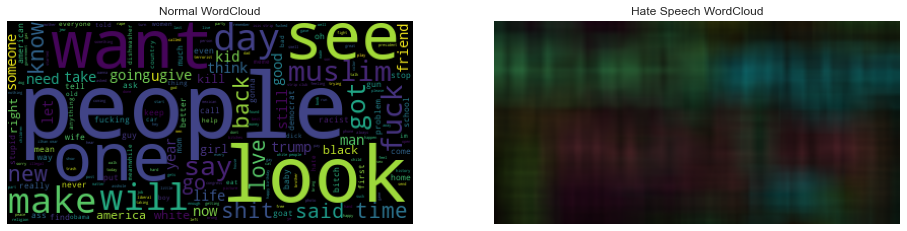

In [20]:
fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
ax[0].axis('off')
ax[0].set_title('Normal WordCloud')
ax[0].imshow(normal_cloud)
ax[1].axis('off')
ax[1].set_title('Hate Speech WordCloud')
hate_img = np.array(hate_cloud)
hate_img = cv2.cvtColor(hate_img, cv2.COLOR_BGR2RGB)
hate_img = cv2.blur(hate_img, (40,40))
ax[1].imshow(hate_img)
plt.show()

In [21]:
X = data['text']
y = data['label']

In [22]:
TEST_SIZE = int(TEST_PROPORTION * len(X))
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=TEST_SIZE, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=TEST_SIZE, stratify=y_train)

In [23]:
assert X_test.shape == X_val.shape and y_test.shape == y_val.shape

In [24]:
preprocessor = Preprocess()
preprocessor = Preprocess(method='WordNetLemmatizer')
X_train,y_train = preprocessor.fit_transform(X_train,y_train)
X_val,y_val = preprocessor.transform(X_val, y_val)
X_test, y_test = preprocessor.transform(X_test,y_test)

In [25]:
models = {
    'Logistic':LogisticRegression(class_weight='balanced'),
    'DecisionTree':DecisionTreeClassifier(class_weight='balanced'),
    'RandomForest':RandomForestClassifier(class_weight='balanced',n_jobs=-1),
    'XGBoost':XGBClassifier(objective='binary:logistic',eval_metric='logloss',use_label_encoder=False, n_jobs=-1)
}
fitted_models = {}

In [26]:
def evaluate(model):
    model.fit(X_train,y_train)
    trainPreds = model.predict(X_train)
    valPreds = model.predict(X_val)

    header = '='*50 + f'Evaluating {model.__class__.__name__}' + '='*50
    print(header)
    print('Classification report for train set')
    print(classification_report(y_true=y_train, y_pred=trainPreds))
    print('Classification report on validation set')
    print(classification_report(y_true=y_val, y_pred=valPreds))
    return model

In [27]:
for name, model in models.items():
    fitted_models[name] = evaluate(model)

==================================================Evaluating LogisticRegression==================================================
Classification report for train set
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2440
           1       0.81      0.84      0.82      2440

    accuracy                           0.82      4880
   macro avg       0.82      0.82      0.82      4880
weighted avg       0.82      0.82      0.82      4880

Classification report on validation set
              precision    recall  f1-score   support

           0       0.64      0.60      0.62       305
           1       0.63      0.67      0.65       305

    accuracy                           0.63       610
   macro avg       0.64      0.63      0.63       610
weighted avg       0.64      0.63      0.63       610

==================================================Evaluating DecisionTreeClassifier==================================================
Classi

In [28]:
best_model = fitted_models['XGBoost']

In [29]:
print(classification_report(y_true=y_test, y_pred=best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.72      0.53      0.61       305
           1       0.63      0.79      0.70       305

    accuracy                           0.66       610
   macro avg       0.67      0.66      0.65       610
weighted avg       0.67      0.66      0.65       610



In [30]:
train_proba = best_model.predict_proba(X_train)
val_proba = best_model.predict_proba(X_val)
test_proba = best_model.predict_proba(X_test)

In [31]:
train_roc = roc_auc_score(y_true=y_train, y_score=train_proba[:,1])
val_roc = roc_auc_score(y_true=y_val, y_score=val_proba[:,1])
test_roc = roc_auc_score(y_true=y_test, y_score=test_proba[:,1])
print(f'The roc auc score on train set is -> {train_roc}')
print(f'The roc auc score on val set is -> {val_roc}')
print(f'The roc auc score on test set is -> {test_roc}')

The roc auc score on train set is -> 0.8686009305294276
The roc auc score on val set is -> 0.6892287019618382
The roc auc score on test set is -> 0.6725235151840903


In [32]:
params = {
    'learning_rate': [0.001,0.01,0.1,0.2],
    'n_estimators':[50,75,100,125]
}

In [33]:
best_tuned = GridSearchCV(best_model, params, scoring='f1', cv=3, n_jobs=-1)
best_tuned.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=0, gpu_id=-1,
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                    

In [34]:
best_tuned.best_params_

{'learning_rate': 0.1, 'n_estimators': 50}

In [35]:
xgb_best = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss', 
    use_label_encoder=False,
    n_jobs=-1, 
    **best_tuned.best_params_)

In [36]:
xgb_best.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [37]:
trainPreds = xgb_best.predict(X_train)
valPreds = xgb_best.predict(X_val)
testPreds = xgb_best.predict(X_test)

In [38]:
print(classification_report(y_true=y_train, y_pred=trainPreds))

              precision    recall  f1-score   support

           0       0.83      0.47      0.60      2440
           1       0.63      0.91      0.74      2440

    accuracy                           0.69      4880
   macro avg       0.73      0.69      0.67      4880
weighted avg       0.73      0.69      0.67      4880



In [39]:
print(classification_report(y_true=y_val, y_pred=valPreds))

              precision    recall  f1-score   support

           0       0.76      0.46      0.57       305
           1       0.61      0.85      0.71       305

    accuracy                           0.66       610
   macro avg       0.69      0.66      0.64       610
weighted avg       0.69      0.66      0.64       610



In [40]:
print(classification_report(y_true=y_test, y_pred=testPreds))

              precision    recall  f1-score   support

           0       0.75      0.39      0.52       305
           1       0.59      0.87      0.70       305

    accuracy                           0.63       610
   macro avg       0.67      0.63      0.61       610
weighted avg       0.67      0.63      0.61       610



In [41]:
train_proba = xgb_best.predict_proba(X_train)
val_proba = xgb_best.predict_proba(X_val)
test_proba = xgb_best.predict_proba(X_test)

In [42]:
train_roc = roc_auc_score(y_true=y_train, y_score=train_proba[:,1])
val_roc = roc_auc_score(y_true=y_val, y_score=val_proba[:,1])
test_roc = roc_auc_score(y_true=y_test, y_score=test_proba[:,1])
print(f'The roc auc score on train set is -> {train_roc}')
print(f'The roc auc score on val set is -> {val_roc}')
print(f'The roc auc score on test set is -> {test_roc}')

The roc auc score on train set is -> 0.7554465365493146
The roc auc score on val set is -> 0.6924213920988982
The roc auc score on test set is -> 0.6673206127385112


In [43]:
with open('models/imageModel.pkl', 'wb') as f:
    joblib.dump(xgb_best, f)

In [44]:
preprocessor.predictNew('We are giving our NLP presentation today',model=xgb_best)

'Normal'